In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


In [3]:
# Check number of records before and after dropping duplicates
print('Number of records before dropping duplicates: {}'.format(train_df.shape[0]))
train_df.drop_duplicates(inplace=True)
print('Number of records after dropping duplicates: {}'.format(train_df.shape[0]))

Number of records before dropping duplicates: 60000
Number of records after dropping duplicates: 59727


# Analyse the categorical variables

In [4]:
categoricals = ['town', 'street_name', 'flat_type', 'flat_model', 'furnished', 'subzone', 'planning_area', 'region']
for cat in categoricals:
    unique_values = train_df[cat].unique()
    print(f'Number of unique values in \'{cat}\': {len(unique_values)}')
    print(f'Unique values in \'{cat}\': {np.sort(unique_values)}')
    print('--------------------------------------')

Number of unique values in 'town': 26
Unique values in 'town': ['ang mo kio' 'bedok' 'bishan' 'bukit batok' 'bukit merah' 'bukit panjang'
 'bukit timah' 'central' 'choa chu kang' 'clementi' 'geylang' 'hougang'
 'jurong east' 'jurong west' 'kallang/whampoa' 'marine parade' 'pasir ris'
 'punggol' 'queenstown' 'sembawang' 'sengkang' 'serangoon' 'tampines'
 'toa payoh' 'woodlands' 'yishun']
--------------------------------------
Number of unique values in 'street_name': 1083
Unique values in 'street_name': ['Admiralty Drive' 'Admiralty Link' 'Ah Hood Road' ... 'yung ping road'
 'yung sheng road' 'zion road']
--------------------------------------
Number of unique values in 'flat_type': 9
Unique values in 'flat_type': ['2 room' '2-room' '3 room' '3-room' '4 room' '4-room' '5 room' '5-room'
 'executive']
--------------------------------------
Number of unique values in 'flat_model': 19
Unique values in 'flat_model': ['2-room' '3gen' 'adjoined flat' 'apartment' 'dbss' 'improved'
 'maisonette'

Actions
1. Drop 'furnished' since all have the same value
2. Clean text to merge categories in 'flat_type' e.g. 5-room and 5 room 

In [5]:
train_df.drop(columns=['furnished'], inplace=True)
train_df['flat_type'] = train_df['flat_type'].str.replace('-', ' ')

In [6]:
train_df['flat_type'].unique()

array(['3 room', '4 room', 'executive', '5 room', '2 room'], dtype=object)

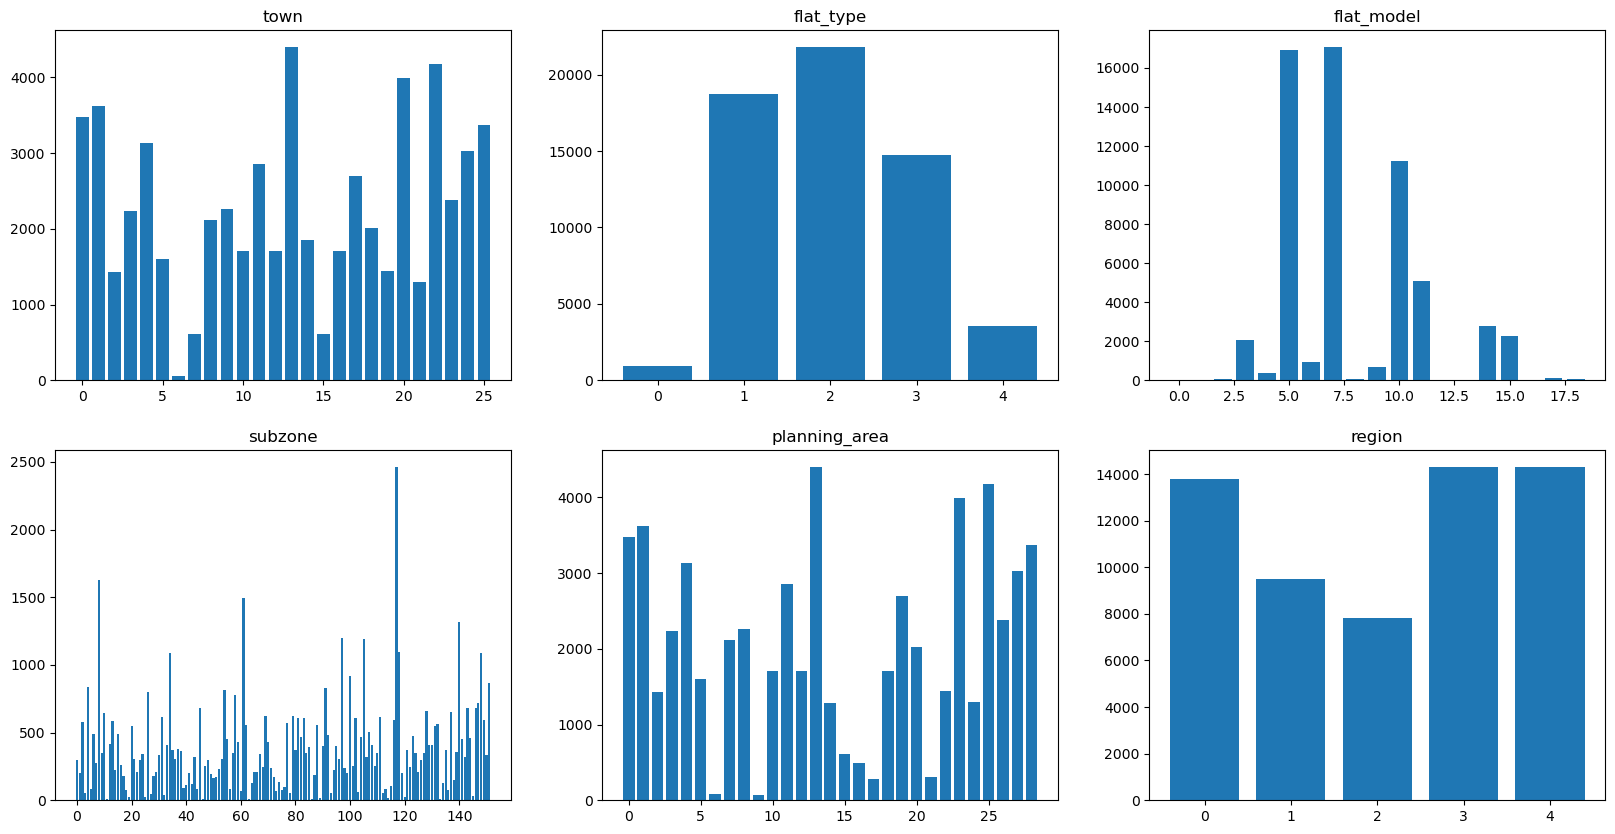

In [7]:
categoricals = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region']
n = 3
fig,ax = plt.subplots(2, n, figsize=(20, 10))
for i, cat in enumerate(categoricals):
    unique_values, counts = np.unique(train_df[cat].values, return_counts=True)
    ax[i//n, i%n].bar(np.arange(len(unique_values)), counts)
    ax[i//n, i%n].set_title(cat)

### Analyse low frequency towns

In [8]:
towns, counts = np.unique(train_df['town'].values, return_counts=True)
print(f'Lowest frequncy town is {towns[counts.argmin()]} with {counts[counts.argmin()]} counts')

Lowest frequncy town is bukit timah with 56 counts


# Analyse numerical variables

In [9]:
train_df.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent
count,59727.000000,59727.000000,59727.000000,59727.000000,59727.0,59727.000000
mean,94.539664,1990.898572,1.359515,103.840102,0.0,2590.986489
std,24.086918,12.131478,0.042483,0.071670,0.0,714.954344
min,34.000000,1966.000000,1.270380,103.685228,0.0,300.000000
25%,73.000000,1981.000000,1.331008,103.778700,0.0,2100.000000
50%,93.000000,1988.000000,1.354170,103.845333,0.0,2400.000000
75%,110.000000,2000.000000,1.387007,103.897505,0.0,3050.000000
max,215.000000,2019.000000,1.457071,103.964915,0.0,6950.000000


# Auxiliary data

### MRTs

In [10]:
mrt_exist_df = pd.read_csv('./data/auxiliary-data/sg-mrt-existing-stations.csv')
print(f'Number of MRT stations: {mrt_exist_df.shape[0]}')
mrt_exist_df.head()

Number of MRT stations: 162


,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418


<Axes: ylabel='Frequency'>

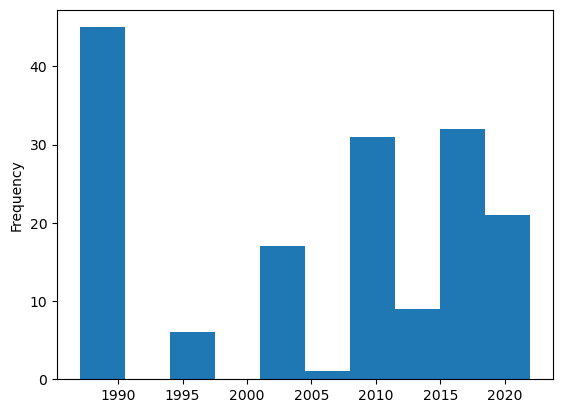

In [11]:
mrt_exist_df['opening_year'].plot(kind='hist', bins=10)

In [12]:
mrt_exist_df['code'].str[:2].unique()

array(['NS', 'EW', 'CG', 'NE', 'CC', 'CE', 'DT', 'TE'], dtype=object)

In [13]:
mrt_planned_df = pd.read_csv('./data/auxiliary-data/sg-mrt-planned-stations.csv')
mrt_planned_df.head()

,code,name,opening_year,latitude,longitude
0,NaN,Brickland,2030,1.369700,103.747900
1,NaN,Sungei Kadut,2030,1.413300,103.748800
2,NaN,Punggol Coast,2024,1.415280,103.911110
3,NaN,Bukit Brown,TBA,1.333639,103.830075
4,NaN,Keppel,2026,1.270100,103.831000


### Schools

In [14]:
schools_df = pd.read_csv('./data/auxiliary-data/sg-primary-schools.csv')
print(f'Number of primary schools: {schools_df.shape[0]}')
schools_df.head()

Number of primary schools: 185


,name,latitude,longitude
0,Admiralty Primary School,1.454038,103.817436
1,Ahmad Ibrahim Primary School,1.433153,103.832942
2,Ai Tong School,1.360583,103.833020
3,Alexandra Primary School,1.291334,103.824425
4,Anchor Green Primary School,1.390370,103.887165


In [15]:
schools_df['name'] = schools_df['name'].str.replace(' School', '')
schools_df['name'] = schools_df['name'].str.replace(' Primary', '')
schools_df['name'] = schools_df['name'].str.replace(' (Primary)', '')
schools_df['name'] = schools_df['name'].str.replace(' (Primary Section)', '')
schools_df['name'] = schools_df['name'].str.replace('\'', '')
schools_df['name'] = schools_df['name'].str.replace('’', '')

In [16]:
school_ballot_df = pd.read_csv('./data/auxiliary-data/sg-school-balloting.csv')
school_ballot_df.head()

,School,Phase 1,2A,2B,2C,2C(S),3
0,Admiralty,NaN,NaN,NaN,NaN,NaN,NaN
1,↳ Vacancy (210),150.0,75,34,70,0,-
2,↳ Applied,75.0,32,37,109,-,-
3,↳ Taken,75.0,32,34,70,-,-
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
school_ballot_df['School'] = school_ballot_df['School'].str.replace('↳ ', '')
# Remove unnecessary rows
school_idx = school_ballot_df['School'].str.startswith('Vacancy').shift(-1)
vacancy_idx = school_ballot_df['School'].str.startswith('Vacancy')
applied_idx = school_ballot_df['School'].str.startswith('Applied')
school_ballot_df = school_ballot_df[school_idx | vacancy_idx | applied_idx]
school_ballot_df.head()

,School,Phase 1,2A,2B,2C,2C(S),3
0,Admiralty,NaN,NaN,NaN,NaN,NaN,NaN
1,Vacancy (210),150.0,75,34,70,0,-
2,Applied,75.0,32,37,109,-,-
6,Ahmad Ibrahim,NaN,NaN,NaN,NaN,NaN,NaN
7,Vacancy (220),160.0,106,52,157,130,115


In [18]:
vacancy_idx = school_ballot_df['School'].str.startswith('Vacancy')
applied_idx = school_ballot_df['School'].str.startswith('Applied')
school_idx = ~(vacancy_idx | applied_idx)
phase_cols = school_ballot_df.columns[1:]
for col in phase_cols[:-2]:
    school_ballot_df.loc[school_idx, col] = (pd.to_numeric(school_ballot_df.loc[applied_idx, col]).values /
                                             pd.to_numeric(school_ballot_df.loc[vacancy_idx, col]).values)
final_school_ballot_df = school_ballot_df.loc[school_idx, school_ballot_df.columns[:-2]]
final_school_ballot_df['School'] = final_school_ballot_df['School'].str.replace('\'', '')
final_school_ballot_df['School'] = final_school_ballot_df['School'].str.replace('’', '')
final_school_ballot_df['School'] = final_school_ballot_df['School'].str.replace(' (Primary)', '')
final_school_ballot_df['School'] = final_school_ballot_df['School'].str.replace(' (Primary Section)', '')
final_school_ballot_df.head()

,School,Phase 1,2A,2B,2C
0,Admiralty,0.500000,0.426667,1.088235,1.557143
6,Ahmad Ibrahim,0.337500,0.09434,0.0,0.171975
10,Ai Tong,0.475000,0.952381,2.545455,1.733333
16,Alexandra,0.407143,0.156627,0.093023,1.110236
22,Anchor Green,0.472222,0.315789,0.0,0.28125


In [20]:
common_names = np.intersect1d(schools_df['name'].values, final_school_ballot_df['School'].values)
unmatched_names1 = np.setdiff1d(schools_df['name'].values, final_school_ballot_df['School'].values)
unmatched_names2 = np.setdiff1d(final_school_ballot_df['School'].values, schools_df['name'].values)

In [21]:
unmatched_names1, unmatched_names2

(array(['Coral', 'Da Qiao', 'East Coast', 'East View', 'Juying', 'Pioneer'],
       dtype=object),
 array(['Fern Green', 'Northshore'], dtype=object))

In [23]:
final_school_ballot_df.to_csv('./data/auxiliary-data/sg-school-balloting-processed.csv', index=False)
schools_df.to_csv('./data/auxiliary-data/sg-primary-schools-processed.csv', index=False)

### Shopping mall

In [22]:
mall_df = pd.read_csv('./data/auxiliary-data/sg-shopping-malls.csv')
mall_df.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635
